<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EDA-and-Feature-Engineering" data-toc-modified-id="EDA-and-Feature-Engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA and Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Reviewing-words-in-the-Dataset" data-toc-modified-id="Reviewing-words-in-the-Dataset-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Reviewing words in the Dataset</a></span></li></ul></li></ul></div>

### EDA and Feature Engineering

In our EDA section, we will be reducing our data to its root words while removing stop words.

In [1]:
# Import necessary libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

Of the two text normalization techniques, lemmatization and stemmatization, we will only be utilizing lemmatization due to the importance of and distinguishing between the exact words typed/used. While Stemmatization may be fast, it disregards many forms of words with the same root which may not share similar meanings in similar contexts.

In [1]:
# Our lemmatizing and stemmatizing function

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords, wordnet # Import the stopword list
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

def nltk2wn_tag(nltk_tag):
    '''
    Function matches a tokenized word with its tag for more accurate lemmatization.
    Returns word's tag.
    '''
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:                    
        return None

def convert_words(data_text):
    '''
    Function takes a text and either lemmatizes its content.
    Returns a string of tokens if a token is not a stopword.
    '''
    nltk_tagged = pos_tag(tokenizer.tokenize(data_text.lower()))
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
    res_words = []
    for word, tag in wn_tagged:
        if tag is None:                        
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join([word for word in res_words if word not in set(stopwords.words('english'))])

In [3]:
data = pd.read_csv('../datasets/adhd_ocd_210313.csv')

In [4]:
data['subreddit'].unique()

array(['ADHD', 'OCD'], dtype=object)

In [5]:
data['subreddit'] = data['subreddit'].map({'ADHD': 0, 'OCD': 1})
data.head()

,subreddit,selftext,title
0,0,Got a good grade on a test? A new promotion at...,What are you proud of today?
1,0,Woohoo I am officially done today! I have spen...,Guyss I just finished my PHD!!
2,0,Dr. Andrew Huberman is a professor at Stanford...,I learned something about sleep that you might...
3,0,So this morning I finally made a doctors appoi...,I've finally made a doctors appointment! And a...
4,0,I am not stupid. I can do a whole lot and I k...,It feels like ADHD is robbing me of my potential


Since both title and selftexts are text types, we will simply combine them for further use.

In [6]:
# Fill NaN selftexts with a space to allow title and selftext to be combined.
data['selftext'].fillna(' ', inplace=True)

In [7]:
# Combine title and selftext into 1 cell

data['content'] = data['title'] + ' ' + data['selftext']

From observation, we know that Reddit selftext tends to have links within it. Does our data have any links in them?

In [8]:
data.loc[data['content'].str.contains('http')].head()

,subreddit,selftext,title,content
8,0,A colleague forwarded me [this article](https:...,"Article on ""Pandemic Brain"" reads like a descr...","Article on ""Pandemic Brain"" reads like a descr..."
251,0,And it feels like the most grown up item I've ...,I impulse bought a pill dispenser the other da...,I impulse bought a pill dispenser the other da...
292,0,I’ve been reading a lot about the ways in whic...,Is your distraction caused by external or inte...,Is your distraction caused by external or inte...
348,0,M.E.D.S\n\n[One year free subscription to medi...,ADHD treatments that worked for me after a who...,ADHD treatments that worked for me after a who...
357,0,Love LOVE 'How to ADHD' on youtube!\n\n[https:...,Perfectionism and ADHD,Perfectionism and ADHD Love LOVE 'How to ADHD'...


Let's take a closer look at row 8.

In [9]:
data.loc[8,'content']

'Article on "Pandemic Brain" reads like a description of my ADHD A colleague forwarded me [this article](https://www.theatlantic.com/health/archive/2021/03/what-pandemic-doing-our-brains/618221/) about "Pandemic Brain" and I just found it to be heartbreaking and ironically amusing. For example, here\'s a description of what the author is experiencing:\n\n&gt; Sometimes I grasp at a word or a name. Sometimes I walk into the kitchen and find myself bewildered as to why I am there. (At one point during the writing of this article, I absentmindedly cleaned my glasses with nail-polish remover.) Other times, the forgetting feels like someone is taking a chisel to the bedrock of my brain, prying everything loose. \n\nIt\'s like: Yeah.  That\'s me ALL THE TIME.  That was me on my BEST days BEFORE the pandemic.\n\nAnother quote:\n\n&gt; Everywhere I turn, the fog of forgetting has crept in. A friend of mine recently confessed that the morning routine he’d comfortably maintained for a decade—wak

From this text, we can see that links are contained in parentheses and typically starting with HTTP. This makes using a regexp to find them simple. For this exercise, and the often random nature of hyperlink text, we will be fully omitting them from our data.

We will also be removing our line breaks (\n) and non-breaking spaces (\xa0) where the are present in our data.

Furthermore, we will remove self-referential acronyms ADHD and OCD from all text. This is to train the chat bot to not work with statements by enquirers declaring their condition, which may not be accurate and produce prediction errors unnecessarily. 'ADHD' and 'OCD' in our texts will surely be highly predictive words in the context of this project and will lead our model to have a much higher accuracy than we expect in production.

In [10]:
# Remove \xa0, \n and links from combined text

# Regexp to capture hyperlinks within ( and )
link_regexp = r'\((http|ftp|file)(.*?)\)'

data['content_mod'] = data['content'].map(lambda x: re.sub(link_regexp, '', str(x).lower()\
                                                           .replace('\xa0', '')\
                                                           .replace('\n', '')\
                                                           .replace('adhd', '').replace('ocd', '')\
                                                          ))

In [11]:
# Lemmatize words according to code above. This line will take some time!
data['content_mod'] = data['content_mod'].map(lambda x: convert_words(x))                                           

In [12]:
data.columns

Index(['subreddit', 'selftext', 'title', 'content', 'content_mod'], dtype='object')

Let's take a look at our lemmatized content in row 8 again.

In [13]:
data.loc[8, 'content_mod']

'article pandemic brain read like description colleague forward article pandemic brain find heartbreaking ironically amuse example description author experience gt sometimes grasp word name sometimes walk kitchen find bewilder one point writing article absentmindedly clean glass nail polish remover time forgetting feel like someone take chisel bedrock brain pry everything loose like yeah time best day pandemic another quote gt everywhere turn fog forgetting creep friend mine recently confess morning routine comfortably maintain decade wake 7 shower dress get subway feel unimaginable literal level cannot put back every single day pandemic one gt jen george community college teacher cape elizabeth maine tell lose train thought middle sentence often meanwhile third grader attend person school keep leave book paper lunch home inny ekeolu 19 year old student ireland say find forget thing use regular basis swipe bus pas pay grocery argh function normally doom gloom thrill notion finally able

As expected, the hyperlink previously in the content is gone, as with most common stop words. There are also no line breaks and non-breaking spaces.

#### Reviewing words in the Dataset

With the help of word clouds, we can take a glance at the most common words in our data.

In [14]:
def create_and_show_wordcloud(words, bg_color, word_colormap):
    '''
    Function creates a wordcloud of 35 most frequently seen words in 'words' with colours defined.
    words: list of sentences/texts to use in the wordcloud. As with the generate method in WordCloud,
    will be first joined for the functino to detect each words' frequency.
    bg_color: matplotlib colour to use for background
    word_colormap: matplotlib colormap to use for words
    '''
    wordcloud_whole = WordCloud(width=800, height=400, max_words=35, \
                      stopwords = STOPWORDS, background_color=bg_color, colormap=word_colormap, \
                      collocations=False).generate(' '.join(words))
    plt.figure(figsize=(13,13))
    plt.imshow(wordcloud_whole, interpolation='bilInear')
    # No axes for wordclouds
    plt.axis('off')
    # Show wordcloud
    plt.show()

First, let's take a look at the overall content's most common words.

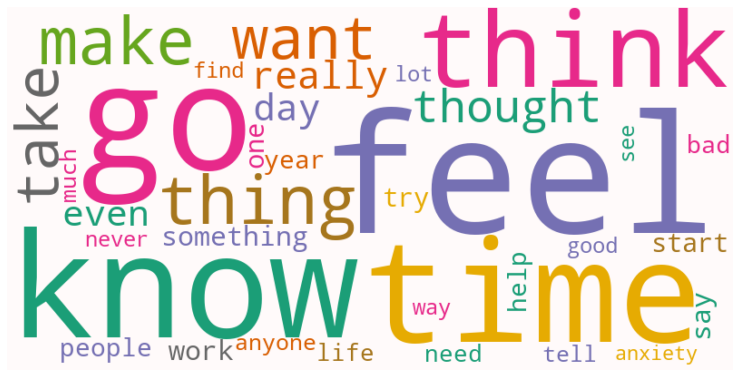

In [15]:
create_and_show_wordcloud(data['content_mod'], 'snow', 'Dark2_r')

At a glance, we see that our text is composed of pretty common words. Above all are the words 'feel', 'know', and 'think' which speaks to the very personal nature of most Reddit posts in both subreddits.

**Next, for the ADHD dataset**

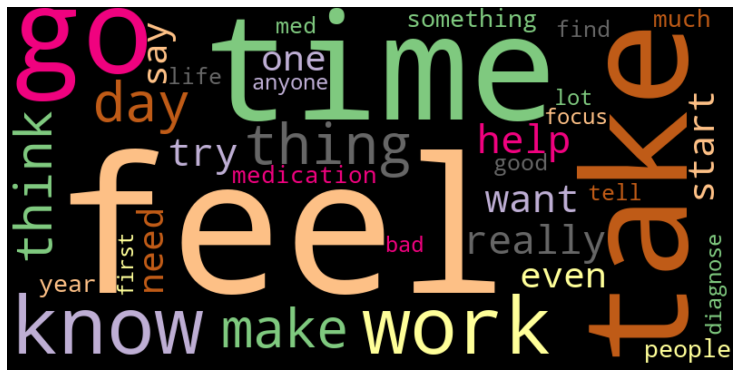

In [16]:
create_and_show_wordcloud(data.loc[data['subreddit'] == 0, 'content_mod'], 'black', 'Accent')

The words here are very similar to the overall dataset, with the many of the most frequent words being identical.

**Now, for the OCD dataset**

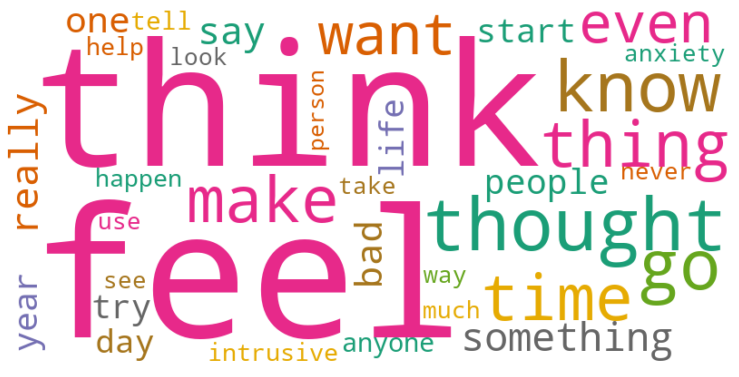

In [17]:
create_and_show_wordcloud(data.loc[data['subreddit'] == 1, 'content_mod'], 'white', 'Dark2')

Yet again, the OCD frequent words are very similar to both the two sets before it. This indicates that modeling could be quite a challenge if each side does not have highly indicative keywords. In our modeling section, we will attempt to find these exact words.

In [18]:
from datetime import date
data[['subreddit', 'content_mod']].to_csv(f'../datasets/adhd_ocd_{date.today().strftime("%y%m%d")}_mod.csv', index=False)